In [1]:
# import
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency

In [2]:
# Read API
API_KEY = ''

with open('ALPHAVANTAGE_API_KEY') as f:
    API_KEY = f.read()

In [3]:
ts = TimeSeries(API_KEY, output_format='pandas', indexing_type='integer') 
ti = TechIndicators(key=API_KEY, output_format='pandas')

In [4]:
def getDailyData(ticker):
    priceData, metaData = ts.get_daily(ticker, outputsize='full')
    return priceData, metaData

In [11]:
# Saver the data in parquet form for speed and compressed form of data
def updateAndSave(new_data, dm):
    filePath = './data'
    fileName = dm['2. Symbol'] + ".csv"
    full_path = os.path.join(filePath, fileName)
    
    # Check if the parquet file exists
    if os.path.exists(full_path):
        # Read the existing parquet file
        existing_data = pd.read_csv(full_path)
        
        # Find rows that are not in the existing data
        updated_data = pd.concat([existing_data, new_data]).drop_duplicates(keep=False, ignore_index=True)
        
        # Combine existing data with unique new rows
        final_data = pd.concat([existing_data, updated_data], ignore_index=True)
    else:
        # If the file does not exist, use the new data as is
        updated_data = new_data
        
    # Save the updated DataFrame back to the parquet file
    updated_data.to_csv(full_path, index=False)

    

In [12]:
# Function to calculate sample mean distribution
def sample_mean_distribution(population, sample_size=30, num_samples=100000):
    sample_means = []
    for _ in range(num_samples):
        sample = np.random.choice(population, size=sample_size, replace=True)
        sample_mean = np.mean(sample)
        sample_means.append(sample_mean)
    return sample_means


In [14]:
# get RSI
def getRSI(df, period=5):
    df.iloc[::-1]
    # Calculate daily price change
    df['change'] = df['4. close'].diff(-1)
    
    # Calculate gains and losses
    df['gain'] = df['change'].apply(lambda x: x if x > 0 else 0)
    df['loss'] = df['change'].apply(lambda x: -x if x < 0 else 0)

    #drop and then reverse order 
    df.dropna()
    df = df[::-1]
    
    # Calculate average gains and losses
    df['avg_gain'] = df['gain'].rolling(window=period, min_periods=1).mean()
    df['avg_loss'] = df['loss'].rolling(window=period, min_periods=1).mean()
    
    # Calculate Relative Strength (RS)
    df['rs'] = df['avg_gain'] / (df['avg_loss']+ 0.000001)
    
    # Calculate RSI
    df['rsi'] = 100 - (100 / (1 + df['rs']))

    # revert back and then shift
    df = df[::-1]
    
    # we want to use previous day rsi to predict today
    df['rsi_prev'] = df['rsi'].shift(-1)

    # dropna
    df.dropna()
    
    # Drop intermediate columns
    df.drop(columns=['change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs'], inplace=True)
    return df

In [59]:
# preprocess the data
def preprocessData(df):
    df['day'] = pd.to_datetime(df['index']).dt.day_of_week
    df['dateTime'] = pd.to_datetime(df['index'])
    df['quarter'] = df['dateTime'].dt.quarter
    df['month'] = df['dateTime'].dt.month
    df['year'] = df['dateTime'].dt.year
    df['dayofyear'] = df['dateTime'].dt.dayofyear
    df['dayofmonth'] = df['dateTime'].dt.day
    df['weekofyear'] = df['dateTime'].dt.isocalendar().week

    df['PnL'] = (df['4. close']-df['1. open'])*100/ df['1. open']
    # Create a new column to estimate outside Regular Trading hours
    # by subtracting the value in the previous days 'closing price' from the current day's 'opening price'
    df['PnL_nonRTH'] = (df['1. open'] - df['4. close'].shift(-1))*100/df['4. close'].shift(-1)
    df['momentum'] = df['4. close'] - df['4. close'].shift(-3)

    # RSI
    df.iloc[::-1]
    # Calculate daily price change
    df['change'] = df['4. close'].diff(-1)
    
    # Calculate gains and losses
    df['gain'] = df['change'].apply(lambda x: x if x > 0 else 0)
    df['loss'] = df['change'].apply(lambda x: -x if x < 0 else 0)

    #drop and then reverse order 
    df.dropna()
    df = df[::-1]
    period = 5
    vol_divider = 1000000
    # Calculate average gains and losses
    df['avg_gain'] = df['gain'].rolling(window=period, min_periods=1).mean()
    df['avg_loss'] = df['loss'].rolling(window=period, min_periods=1).mean()
    
    # Calculate Relative Strength (RS)
    df['rs'] = df['avg_gain'] / (df['avg_loss']+ 0.000001)
    
    # Calculate RSI
    df['rsi'] = 100 - (100 / (1 + df['rs']))

    # revert back and then shift
    df = df[::-1]
    
    # we want to use previous day rsi and momentum to predict today
    # x = past 3 day's [ rsi, open/close/low/high price, vol, momentum] and todays' opening price
    # y = today's [low and high prices]
    df['rsi_p1'] = df['rsi'].shift(-1)
    df['rsi_p2'] = df['rsi'].shift(-2)
    df['rsi_p3'] = df['rsi'].shift(-3)
    df['mom_p1'] = df['momentum'].shift(-1)
    df['mom_p2'] = df['momentum'].shift(-2)
    df['mom_p3'] = df['momentum'].shift(-3)
    df['open_p1'] = df['1. open'].shift(-1)
    df['open_p2'] = df['1. open'].shift(-2)
    df['open_p3'] = df['1. open'].shift(-3)
    df['high_p1'] = df['2. high'].shift(-1)
    df['high_p2'] = df['2. high'].shift(-2)
    df['high_p3'] = df['2. high'].shift(-3)
    df['low_p1'] = df['3. low'].shift(-1)
    df['low_p2'] = df['3. low'].shift(-2)
    df['low_p3'] = df['3. low'].shift(-3)
    df['close_p1'] = df['4. close'].shift(-1)
    df['close_p2'] = df['4. close'].shift(-2)
    df['close_p3'] = df['4. close'].shift(-3)
    df['vol_p1'] = df['5. volume'].shift(-1)/vol_divider
    df['vol_p2'] = df['5. volume'].shift(-2)/vol_divider
    df['vol_p3'] = df['5. volume'].shift(-3)/vol_divider
    df['open_today'] = df['1. open']

    df['true_high'] = df['2. high']
    df['true_low'] = df['3. low']

    # dropna
    df = df.dropna()
    
    # Drop intermediate columns
    df.drop(columns=['change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs'], inplace=True)

    return df

# df = df.dropna(subset=['PnL_nonRTH', 'momentum', 'rsi'])
    

In [53]:
original_data, dm = getDailyData('META')
original_data.shape

(3092, 6)

In [60]:
df = preprocessData(original_data.copy())
df.head()

,index,1. open,2. high,3. low,4. close,5. volume,day,dateTime,quarter,month,...,low_p3,close_p1,close_p2,close_p3,vol_p1,vol_p2,vol_p3,open_today,true_high,true_low
index,,,,,,,,,,,,,,,,,,,,,
0,2024-09-03,519.640,525.490,508.6176,511.76,12074282.0,1,2024-09-03,3,9,...,512.45,521.31,518.22,516.78,9.157541,8.317424,9.106077,519.640,525.490,508.6176
1,2024-08-30,521.350,523.540,515.2000,521.31,9157541.0,4,2024-08-30,3,8,...,515.31,518.22,516.78,519.10,8.317424,9.106077,6.282720,521.350,523.540,515.2000
2,2024-08-29,519.050,527.200,515.6789,518.22,8317424.0,3,2024-08-29,3,8,...,514.95,516.78,519.10,521.12,9.106077,6.282720,9.584002,519.050,527.200,515.6789
3,2024-08-28,517.675,521.085,512.4500,516.78,9106077.0,2,2024-08-28,3,8,...,525.06,519.10,521.12,528.00,6.282720,9.584002,11.323936,517.675,521.085,512.4500
4,2024-08-27,518.980,524.010,515.3100,519.10,6282720.0,1,2024-08-27,3,8,...,528.59,521.12,528.00,531.93,9.584002,11.323936,15.708292,518.980,524.010,515.3100


In [61]:
df.isnull().values.any()

False

## Base model: Linear Regression (2 seperate model for low and high price prediction)

In [47]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [62]:
x_features = ['rsi_p1', 'rsi_p2', 'rsi_p3', 'mom_p1', 'mom_p2', 'mom_p3', 'open_p1', 'open_p2', 'open_p3', 
              'high_p1', 'high_p2', 'high_p3', 'low_p1', 'low_p2', 'low_p3', 'close_p1', 'close_p2', 'close_p3',
              'vol_p1', 'vol_p2', 'vol_p3', 'open_today']

y_targets = [['true_high'], ['true_low']]

In [63]:
X = df[x_features]
y = df[y_targets[0]]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

Mean Squared Error: 5.345416224298824
R^2 Score: 0.9996092298612543
Coefficients: [[-3.94802789e-04  2.99629795e-03 -1.54040474e-03  6.25776943e-02
  -3.06961093e-02 -2.40516973e-03 -6.27473922e-03  4.28434339e-03
   7.18312602e-02  1.41160463e-01  1.55711956e-01  8.02099406e-02
  -7.32498981e-02 -5.09555781e-02 -1.29326205e-01 -1.11583413e-01
  -4.05799974e-02 -1.03279869e-02  4.70503467e-03 -6.29363504e-04
  -8.76235933e-04  9.74498806e-01]]
Intercept: [-0.21572008]


In [77]:
test_data = preprocessData(original_data.head(10).copy())

In [78]:
test_data.loc[:,['2. high']], model.predict(test_data.loc[:, x_features])

(       2. high
 index         
 0      525.490
 1      523.540
 2      527.200
 3      521.085,
 array([[525.57556599],
        [527.14858097],
        [525.27202871],
        [524.5589006 ]]))

### Polynomial regression

In [76]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [82]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)
y_pred_poly = poly_model.predict(poly.transform(X_test))

mse = mean_squared_error(y_test, y_pred_poly)
r2 = r2_score(y_test, y_pred_poly)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 14.35240248748346
R^2 Score: 0.9989507851070841


In [83]:
test_data.loc[:,['2. high']], poly_model.predict(poly.transform(test_data.loc[:, x_features]))

(       2. high
 index         
 0      525.490
 1      523.540
 2      527.200
 3      521.085,
 array([[526.66517792],
        [526.98681646],
        [528.03566918],
        [522.80112466]]))

In [85]:
from sklearn.svm import SVR

svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train.values.ravel())
y_pred_svr = svr_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 898.0267932210664
R^2 Score: 0.9343508456854732


In [86]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_tree)
r2 = r2_score(y_test, y_pred_tree)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 10.815592276860846
R^2 Score: 0.9992093393073053


In [87]:
test_data.loc[:,['2. high']], tree_model.predict(test_data.loc[:, x_features])

(       2. high
 index         
 0      525.490
 1      523.540
 2      527.200
 3      521.085,
 array([527.2  , 523.54 , 527.2  , 521.085]))

In [109]:
# lets predict for tomorrow
# first shift the data
tomorrow = test_data.copy()
tomorrow

,index,1. open,2. high,3. low,4. close,5. volume,day,dateTime,quarter,month,...,low_p3,close_p1,close_p2,close_p3,vol_p1,vol_p2,vol_p3,open_today,true_high,true_low
index,,,,,,,,,,,,,,,,,,,,,
0,2024-09-03,519.640,525.490,508.6176,511.76,12074282.0,1,2024-09-03,3,9,...,512.45,521.31,518.22,516.78,9.157541,8.317424,9.106077,519.640,525.490,508.6176
1,2024-08-30,521.350,523.540,515.2000,521.31,9157541.0,4,2024-08-30,3,8,...,515.31,518.22,516.78,519.10,8.317424,9.106077,6.282720,521.350,523.540,515.2000
2,2024-08-29,519.050,527.200,515.6789,518.22,8317424.0,3,2024-08-29,3,8,...,514.95,516.78,519.10,521.12,9.106077,6.282720,9.584002,519.050,527.200,515.6789
3,2024-08-28,517.675,521.085,512.4500,516.78,9106077.0,2,2024-08-28,3,8,...,525.06,519.10,521.12,528.00,6.282720,9.584002,11.323936,517.675,521.085,512.4500


In [136]:
tomorrow['rsi_p3'] = tomorrow['rsi_p2']
tomorrow['rsi_p2'] = tomorrow['rsi_p1']
tomorrow['rsi_p1'] = tomorrow['rsi']

tomorrow['mom_p3'] = tomorrow['mom_p2']
tomorrow['mom_p2'] = tomorrow['mom_p1']
tomorrow['mom_p1'] = tomorrow['momentum']

tomorrow['open_p3'] = tomorrow['open_p2']
tomorrow['open_p2'] = tomorrow['open_p1']
tomorrow['open_p1'] = tomorrow['1. open']

tomorrow['high_p3'] = tomorrow['high_p2']
tomorrow['high_p2'] = tomorrow['high_p1']
tomorrow['high_p1'] = tomorrow['2. high']

tomorrow['low_p3'] = tomorrow['low_p2']
tomorrow['low_p2'] = tomorrow['low_p1']
tomorrow['low_p1'] = tomorrow['3. low']

tomorrow['close_p3'] = tomorrow['close_p2']
tomorrow['close_p2'] = tomorrow['close_p1']
tomorrow['close_p1'] = tomorrow['4. close']

tomorrow['vol_p3'] = tomorrow['vol_p2']
tomorrow['vol_p2'] = tomorrow['vol_p1']
tomorrow['vol_p1'] = tomorrow['5. volume']/1000000

tomorrow['open_today'] = tomorrow['4. close']

In [137]:
tomorrow.loc[0, x_features].values.reshape(1,-1)

array([[24.59282720064398, 24.59282720064398, 24.59282720064398,
        -5.019999999999982, -5.019999999999982, -5.019999999999982,
        519.64, 519.64, 519.64, 525.49, 525.49, 525.49, 508.6176,
        508.6176, 508.6176, 511.76, 511.76, 511.76, 12.074282, 12.074282,
        12.074282, 511.76]], dtype=object)

In [138]:
tree_model.predict(tomorrow.loc[0, x_features].values.reshape(1,-1))

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([521.085])

In [19]:
def predict_periodicity(df, nonRTH = False):
    # Weak model based on statistics, periodcity, human biasness for perticular days of week and randomness of the stock prices
    target = 'PnL'
    if nonRTH: target = 'PnL_nonRTH'
    # Calculate sample mean distribution
    num_samples = 10000
    sample_means = sample_mean_distribution(df[target], num_samples)
    # Calculate the mean of the sample means
    mean_of_sample_means = np.mean(sample_means)
    # Calculate the mean and standard deviation of the sample means
    mean_of_sample_means = np.mean(sample_means)
    std_of_sample_means = np.std(sample_means)
    
    # Calculate the 95% confidence interval for the mean
    confidence_level = 0.95
    z_score = stats.norm.ppf((1 + confidence_level) / 2)
    margin_of_error = z_score * (std_of_sample_means / np.sqrt(num_samples))
    confidence_interval = (mean_of_sample_means - margin_of_error, mean_of_sample_means + margin_of_error)
    
    # Add vertical lines at the mean of sample means and at 0
    plt.axvline(mean_of_sample_means, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_of_sample_means:.4f}')
    plt.axvline(0, color='blue', linestyle='--', linewidth=1.5, label='0')
    
    # Add confidence interval lines
    plt.axvline(confidence_interval[0], color='green', linestyle='--', linewidth=1, label=f'Lower CI: {confidence_interval[0]:.4f}')
    plt.axvline(confidence_interval[1], color='green', linestyle='--', linewidth=1, label=f'Upper CI: {confidence_interval[1]:.4f}')
    
    
    plt.hist(sample_means, bins=30, edgecolor='black', density=True)
    plt.title('Sample Mean Distribution for Friday')
    plt.xlabel('Sample Mean')
    plt.ylabel('Density')
    plt.show()
    lowerBound = confidence_interval[0] - df[target][0:20].mean()
    upperBound = confidence_interval[1] - df[target][0:20].mean()
    return lowerBound, upperBound

def predict_periodicity_based_on_day(df, day, nonRTH = False):
    predict_periodicity(df[df['day'] == day], nonRTH)

def predict_periodicity_based_on_weekofyear(df, weekOfyear, nonRTH = False):
    predict_periodicity(df[df['weekofyear'] == weekOfyear], nonRTH)


In [20]:
# https://medium.com/@smitpate08/unleashing-the-power-of-categorical-relationships-with-pandas-in-python-82fbe3917338
# based on this doc, relationship testing

def correlation_of_columns(data, alpha = 0.05):
    # Get all categorical columns in the DataFrame
    categorical_columns = data.columns
    results = []
    
    # Create a copy of the dataframe to avoid modifying the original
    data_copy = data.copy()
    
    # Remove rows containing missing values
    data_copy = data_copy.dropna(subset=categorical_columns)
    
    # Iterate over each pair of categorical columns
    for i in range(len(categorical_columns)):
        for j in range(i+1, len(categorical_columns)):
            col1 = categorical_columns[i]
            col2 = categorical_columns[j]
            
            # Create the contingency table for the two columns
            contingency_table = pd.crosstab(data_copy[col1], data_copy[col2])
            
            # Calculate the chi-squared test of independence
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            
            # Check if we reject the null hypothesis (i.e., if the columns are dependent)
            reject_null_hypothesis = p < alpha
            dependency = reject_null_hypothesis
            
            # Add the results to the list of results
            results.append({'column': col1, 'column_compared_with': col2, 'p-value': p, 'Null hypothesis rejected': reject_null_hypothesis, 'dependency': dependency})
    return pd.DataFrame(results).sort_values(by='p-value', ascending=False)

In [25]:
features = ['1. open', '2. high', '3. low', '4. close', 'weekofyear', 'PnL', 'PnL_nonRTH', 'momentum_prev', 'rsi_prev']

In [26]:
corr = correlation_of_columns(df[features])

In [27]:
corr[corr['dependency']==True]

,column,column_compared_with,p-value,Null hypothesis rejected,dependency
14,2. high,rsi_prev,3.811471e-02,True,True
10,2. high,weekofyear,3.364966e-02,True,True
12,2. high,PnL_nonRTH,1.749146e-02,True,True
7,1. open,rsi_prev,7.499504e-03,True,True
20,3. low,rsi_prev,7.480077e-03,True,True
8,2. high,3. low,4.516046e-03,True,True
5,1. open,PnL_nonRTH,1.026071e-03,True,True
33,PnL_nonRTH,momentum_prev,6.928258e-04,True,True
15,3. low,4. close,4.547166e-05,True,True
1,1. open,3. low,1.204712e-05,True,True


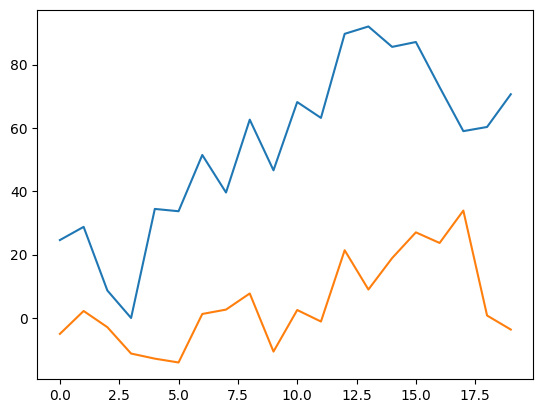

## Lets try XGBoost for time series forcasting

In [69]:
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [70]:
cols = ['day', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'momentum', 'rsi', 'PnL']
FEATURES = ['day', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'rsi', 'momentum']
TARGET = ['PnL']

In [71]:
df = df.dropna()
data = df.loc[:, cols]
data.head()

,day,quarter,month,year,dayofyear,dayofmonth,weekofyear,momentum,rsi,PnL
index,,,,,,,,,,
3,1,3,8,2024,240,27,35,-2.21,33.868613,0.023122
4,0,3,8,2024,239,26,35,2.90,48.928974,-1.228203
5,4,3,8,2024,236,23,34,11.22,71.238095,-1.661328
6,3,3,8,2024,235,22,34,12.83,91.320072,-0.944134
7,2,3,8,2024,234,21,34,14.04,100.000000,1.519492


In [72]:
test = data[0:300]
train = data[300::]

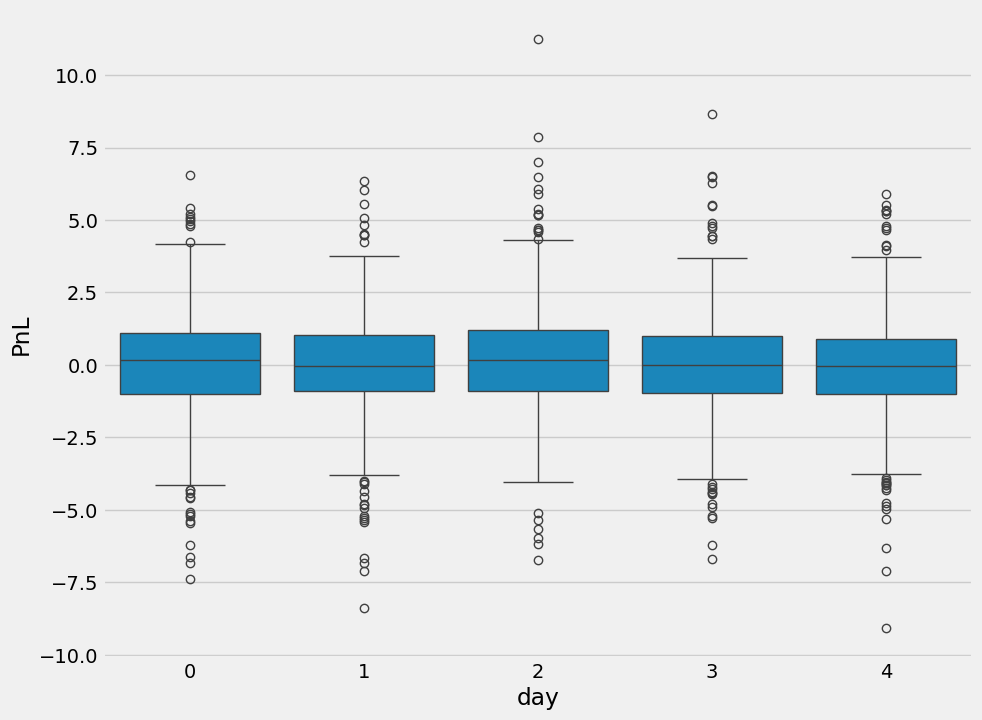

In [73]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=data, x='day', y='PnL')
# ax.set_title('PnL by Day')
plt.show()

In [74]:
X_train = train.loc[:, FEATURES]
y_train = train.loc[:, TARGET]

X_test = test.loc[:, FEATURES]
y_test = test.loc[:, TARGET]

In [75]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=100,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1.88503	validation_1-rmse:1.71221
[99]	validation_0-rmse:1.75216	validation_1-rmse:1.70242


/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:30:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

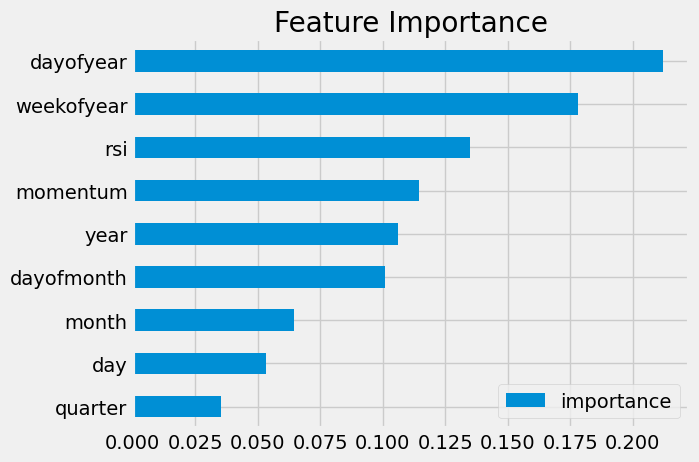

In [76]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [77]:
def getTestData(date):
    # ['day', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
    # Convert the input date string to a datetime object
    sr = pd.Series([date])
    sr = pd.to_datetime(sr) 
    return pd.DataFrame([[sr.dt.day_of_week[0], sr.dt.quarter[0], sr.dt.month[0], sr.dt.year[0], sr.dt.dayofyear[0], sr.dt.day[0], sr.dt.isocalendar().week[0]]], columns=FEATURES)

In [78]:
reg.predict(getTestData('09-02-2024'))

ValueError: 9 columns passed, passed data had 7 columns